In [ ]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
import scipy.signal as signal
from scipy.signal import lfilter
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler




# !sudo apt-get install p7zip-full

In [ ]:
!pip install Gammatone
!pip install butter

from gammatone.gtgram import gtgram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for butter: filename=butter-0.13.1-cp310-cp310-linux_x86_64.whl size=156397 sha256=21c831ed1592d4516beb519e4e155028c5ebfced5f37cd03aa6ec3b7d753f8ea
  Stored in directory: /root/.cache/pip/wheels/c8/bd/29/66b0761bf15e50dce66f96ccf3f3fd6425943beffa8861878b
Successfully built butter


MOUNT GOOGLE DRIVE

In [ ]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"

In [ ]:
from google.colab import drive
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')

Mounted at /content/drive


In [ ]:
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"]

In [ ]:
df_from_save = pd.read_feather(csv_files[0])
df_from_save['key'] = df_from_save['index']
df_from_save.drop(columns=['index'], inplace=True)
df_from_save.set_index('key', inplace=True)
df_from_save.head(3)

,amp,amp_original,sf,sf_original,shape,shape_original,cough_start_end,label
key,,,,,,,,
a24e3cbe-eda1-40b9-8f9d-57c939ef3663,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...","[-6.8540386e-12, -6.674442e-12, 4.356682e-12, ...",16000,22050,[27840],[38367],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28b68991-11d8-48dd-b0ce-ab7bb44f0383,"[1.6255598e-19, 1.224641e-18, -3.2656346e-19, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[157440],[216972],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
0b2f75d7-f116-4f35-ae4c-f2018eab2794,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[155520],[214326],"[[1.651429, 1.891429], [2.022857, 2.331429], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
GDRIVE_COMPONENT_DIR = f"/content/drive/My Drive/23-24_CE903-SU_team06/cough_segmentation/utils/"
print(os.listdir(GDRIVE_COMPONENT_DIR))

import sys
sys.path.append(GDRIVE_COMPONENT_DIR)



['__init__.py', 'feature_extraction.py', 'framing.py', 'simple_ingestion.py', 'sono_cross_val.py', 'utils.py', '__pycache__']


In [ ]:
from framing import Framing

FRAMINGS

Frame size 1024, hop_length 512, count 82957
Frame size 2048, hop_length 1024, count 41222
Hop Length: 512


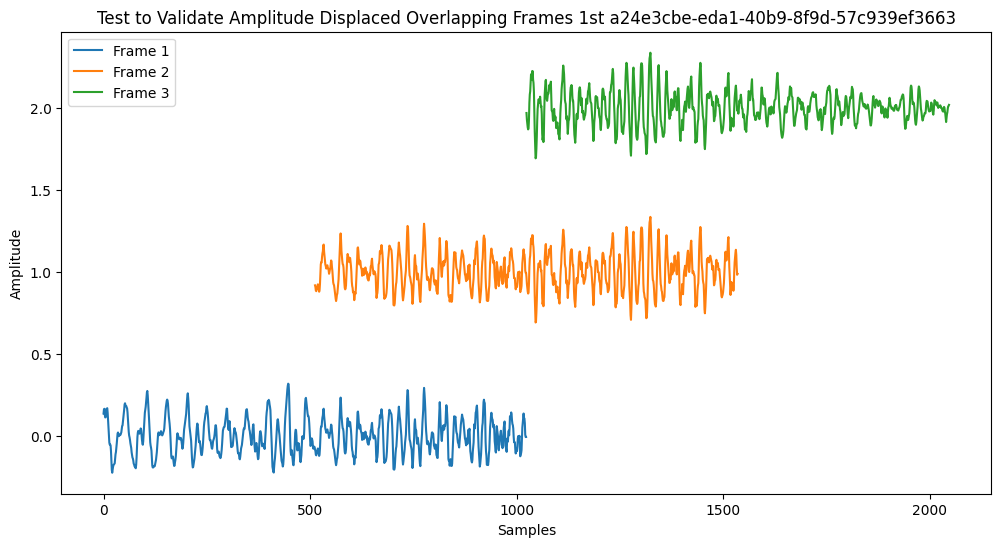

Hop Length: 512


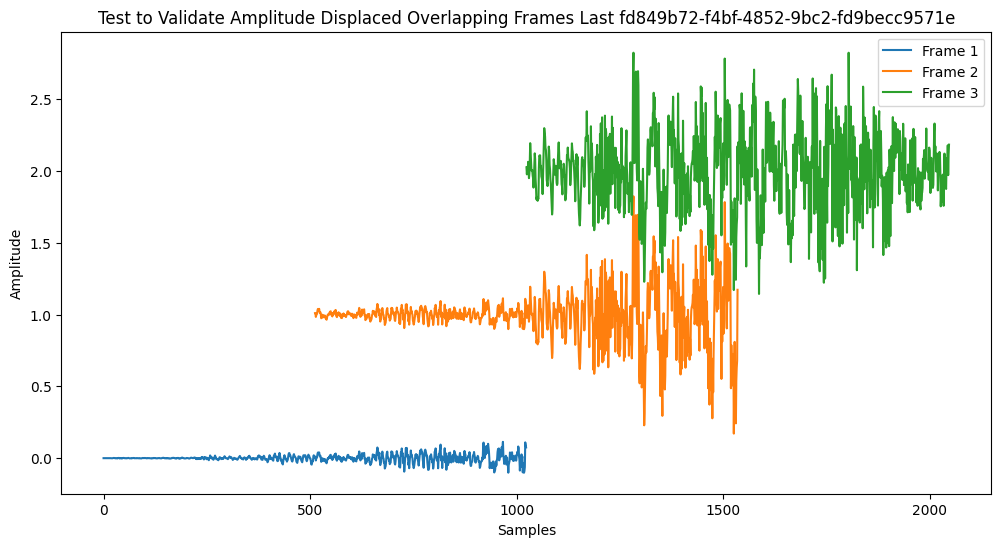

In [ ]:

frame = Framing()

all_frames_from_save = frame.apply_framing(audio_df=df_from_save, frame_sizes=[1024,2048])
df_frame_from_save = all_frames_from_save[1024]
df_frame_from_save.head(3)

visual_set = {"1st":df_frame_from_save.head(1)["key"].values[0],"Last":df_frame_from_save.tail(1)["key"].values[0]}
frame.visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)

Hop Length: 512


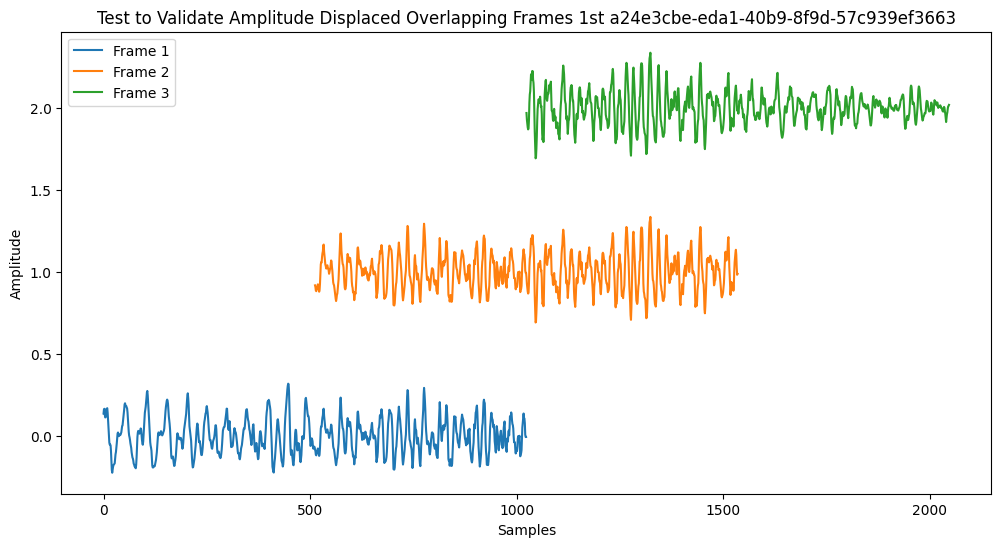

Hop Length: 512


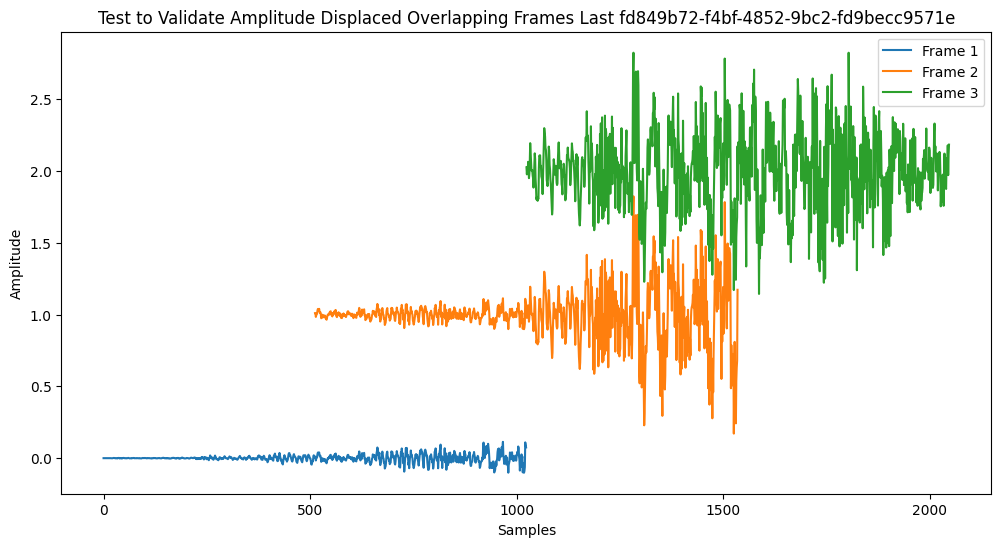

In [ ]:
# Visualize overlapping frames
visual_set = {"1st": df_frame_from_save.head(1)["key"].values[0], "Last": df_frame_from_save.tail(1)["key"].values[0]}
frame.visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)
#plt.show()

In [ ]:
# Inspect the DataFrame columns to ensure the correct column names are used
print(df_frame_from_save.columns)
df_from_save["amp"]

Index(['key', 'sf', 'start', 'end', 'max_amp', 'frame_index', 'amp', 'label'], dtype='object')


key
a24e3cbe-eda1-40b9-8f9d-57c939ef3663    [-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...
28b68991-11d8-48dd-b0ce-ab7bb44f0383    [1.6255598e-19, 1.224641e-18, -3.2656346e-19, ...
0b2f75d7-f116-4f35-ae4c-f2018eab2794    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
d2ce5b46-e4ca-4a35-938a-d18309ec8537    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
eade4e05-0fe3-4736-8a9c-35467d078113    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                                              ...                        
e6448323-4be3-4fac-ba98-33aee0de0817    [-1.4024037e-12, 1.8094825e-12, -1.8148147e-12...
42d1cba8-f6a3-45f3-971b-03e212ce4142    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6147e276-9553-46cf-970c-a5c43309a5fc    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
305898a2-7331-45a4-8080-6fe0947443e9    [1.8791303e-08, -1.5504117e-08, -1.2779726e-08...
fd849b72-f4bf-4852-9bc2-fd9becc9571e    [3.5567125e-20, 6.774533e-20, 2.7358853e-21, 8...
Name: 

In [ ]:
df_frame_from_save

,key,sf,start,end,max_amp,frame_index,amp,label
0,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,0,1024,8.836885e-05,0,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...",0
1,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,512,1536,6.821569e-05,1,"[3.0801788e-05, 6.093162e-05, 3.560784e-05, -6...",0
2,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1024,2048,6.644696e-05,2,"[3.0517596e-05, 3.0517573e-05, 3.0517596e-05, ...",0
3,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1536,2560,2.835689e-08,3,"[-1.41313e-08, 1.9094735e-08, -2.2920153e-08, ...",0
4,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,2048,3072,9.907748e-16,4,"[-1.5186867e-16, -6.784829e-17, 7.3962843e-16,...",0
...,...,...,...,...,...,...,...,...
82952,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,69632,70656,3.533897e-05,136,"[1.4073834e-07, -1.5136347e-07, 1.5978313e-07,...",0
82953,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,70144,71168,2.780168e-12,137,"[1.7115064e-12, 2.0663297e-12, 1.2099997e-12, ...",0
82954,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,70656,71680,1.853762e-06,138,"[-4.7537818e-18, 3.464349e-18, -1.100551e-18, ...",0
82955,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,71168,72192,1.853762e-06,139,"[5.8562245e-14, -1.3361285e-14, 4.9188924e-14,...",0


## **FEATURE EXTRACTION **

## **Gammatone and STFT**

# **FeatureExtractionSpectrogram**

In [ ]:
class FeatureExtractionSpectrogram:
    def stft(self, df):
        """Read audio data and apply short_time_fourier_transform

        Parameters:
        df (pd.DataFrame): Pandas DataFrame

        Return df
        """
        df_from_save["amp"]
        ft = []
        ft_shape = []
        for index, row in df.iterrows():
            n_fft = min(2048, len(row["amp"]))
            amp_filtered = self.apply_gammatone_filter(row["amp"])
            stft = librosa.amplitude_to_db(np.abs(librosa.stft(amp_filtered, n_fft=n_fft)), ref=np.max)
            ft.append(stft)
            ft_shape.append(stft.shape)

        df["stft"] = ft
        df["stft_shape"] = ft_shape

        return df

    def stft_optimized(self, row):
        """Read audio data and apply short_time_fourier_transform in shorter period of time

        Parameters:
        row (pd.DataFrame row): Pandas DataFrame row

        Return row
        """
        amp_filtered = self.apply_gammatone_filter(row["amp"])
        stft = librosa.amplitude_to_db(np.abs(librosa.stft(amp_filtered, n_fft=self.n_fft, hop_length=self.hop_length, win_length=self.win_length)), ref=np.max)
        return stft

    def set_sftt_params(self, n_fft, hop_length, win_length):
        self.hop_length = hop_length
        self.n_fft = n_fft
        self.win_length = win_length
        print(f'using n_fft:{self.n_fft}, hop length:{self.hop_length}, win_length:{self.win_length}')


In [ ]:
df_from_save["amp"]

key
a24e3cbe-eda1-40b9-8f9d-57c939ef3663    [-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...
28b68991-11d8-48dd-b0ce-ab7bb44f0383    [1.6255598e-19, 1.224641e-18, -3.2656346e-19, ...
0b2f75d7-f116-4f35-ae4c-f2018eab2794    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
d2ce5b46-e4ca-4a35-938a-d18309ec8537    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
eade4e05-0fe3-4736-8a9c-35467d078113    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                                              ...                        
e6448323-4be3-4fac-ba98-33aee0de0817    [-1.4024037e-12, 1.8094825e-12, -1.8148147e-12...
42d1cba8-f6a3-45f3-971b-03e212ce4142    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6147e276-9553-46cf-970c-a5c43309a5fc    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
305898a2-7331-45a4-8080-6fe0947443e9    [1.8791303e-08, -1.5504117e-08, -1.2779726e-08...
fd849b72-f4bf-4852-9bc2-fd9becc9571e    [3.5567125e-20, 6.774533e-20, 2.7358853e-21, 8...
Name: 

In [ ]:
# prompt: generate the path to read audio file df_from_save["amp"] for gammatone filter

def get_audio_paths(df_from_save):
  """Generates the path to read audio file for gammatone filter.

  Args:
      df_from_save: Pandas DataFrame containing audio data.

  Returns:
      list: List of paths to read audio files.
  """

  audio_paths = df_from_save["amp"]
  for index, row in df_from_save.iterrows():
    audio_path = f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"
    #audio_paths.append(audio_path)

  return audio_paths

audio_paths = get_audio_paths(df_from_save)
x = audio_paths
print(x)


key
a24e3cbe-eda1-40b9-8f9d-57c939ef3663    [-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...
28b68991-11d8-48dd-b0ce-ab7bb44f0383    [1.6255598e-19, 1.224641e-18, -3.2656346e-19, ...
0b2f75d7-f116-4f35-ae4c-f2018eab2794    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
d2ce5b46-e4ca-4a35-938a-d18309ec8537    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
eade4e05-0fe3-4736-8a9c-35467d078113    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                                              ...                        
e6448323-4be3-4fac-ba98-33aee0de0817    [-1.4024037e-12, 1.8094825e-12, -1.8148147e-12...
42d1cba8-f6a3-45f3-971b-03e212ce4142    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6147e276-9553-46cf-970c-a5c43309a5fc    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
305898a2-7331-45a4-8080-6fe0947443e9    [1.8791303e-08, -1.5504117e-08, -1.2779726e-08...
fd849b72-f4bf-4852-9bc2-fd9becc9571e    [3.5567125e-20, 6.774533e-20, 2.7358853e-21, 8...
Name: 

In [ ]:
# prompt: df_frame_from_save.head(1)['amp'].values[0].shape divide this into subframes of 128

subframes_per_frame = 8
subframe_size = 128

# Extract the audio data from the first row
#audio_data = df_frame_from_save.head(1)['amp'].values[0]
#audio_data = df_from_save['amp'].values[0]
audio_data = df_frame_from_save.head(1)['amp'].values[0]
#audio_data = df_frame_from_save.head(1)['amp'].values[0]


# Divide the audio data into subframes
num_subframes = len(audio_data) // subframe_size
subframes = np.zeros((num_subframes, subframe_size))
for i in range(num_subframes):
    subframes[i] = audio_data[i * subframe_size:(i + 1) * subframe_size]

# Print the shape of the subframes
print(subframes.shape)

(8, 128)


In [ ]:
audio_data = df_frame_from_save.head(1)['amp'].values[0]

In [ ]:
# prompt: read through the code and find the path to wav

audio_path = f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"


In [ ]:
audio_data = df_frame_from_save.head(1)['amp'].values[0]


In [ ]:
audio_data = df_frame_from_save.head(1)['amp'].values[0]

In [ ]:
print(audio_data.shape)
audio_data

(1024,)


array([-1.3439313e-12, -8.8915611e-12,  7.9569702e-12, ...,
        3.0517589e-05,  3.0517565e-05,  3.0517593e-05], dtype=float32)

In [ ]:
df_frame_from_save

,key,sf,start,end,max_amp,frame_index,amp,label
0,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,0,1024,8.836885e-05,0,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...",0
1,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,512,1536,6.821569e-05,1,"[3.0801788e-05, 6.093162e-05, 3.560784e-05, -6...",0
2,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1024,2048,6.644696e-05,2,"[3.0517596e-05, 3.0517573e-05, 3.0517596e-05, ...",0
3,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,1536,2560,2.835689e-08,3,"[-1.41313e-08, 1.9094735e-08, -2.2920153e-08, ...",0
4,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,16000,2048,3072,9.907748e-16,4,"[-1.5186867e-16, -6.784829e-17, 7.3962843e-16,...",0
...,...,...,...,...,...,...,...,...
82952,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,69632,70656,3.533897e-05,136,"[1.4073834e-07, -1.5136347e-07, 1.5978313e-07,...",0
82953,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,70144,71168,2.780168e-12,137,"[1.7115064e-12, 2.0663297e-12, 1.2099997e-12, ...",0
82954,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,70656,71680,1.853762e-06,138,"[-4.7537818e-18, 3.464349e-18, -1.100551e-18, ...",0
82955,fd849b72-f4bf-4852-9bc2-fd9becc9571e,16000,71168,72192,1.853762e-06,139,"[5.8562245e-14, -1.3361285e-14, 4.9188924e-14,...",0


In [ ]:
# prompt: Using dataframe df_frame_from_save: gammatone filter on df_frame_from_save

import numpy as np

def gammatone_filter(df):
  # Calculate the center frequency of each filter
  center_frequencies = np.logspace(np.log10(80), np.log10(5000), num=128)

  # Calculate the bandwidth of each filter
  bandwidths = np.array([center_frequencies[i] / 2 for i in range(len(center_frequencies))])

  # Calculate the filter coefficients
  filter_coefficients = np.zeros((len(center_frequencies), len(df)))


WORKABLE CODE BELOW

In [ ]:
import numpy as np
import librosa
import gammatone
from gammatone import filters
from gammatone import fftweight
import matplotlib.pyplot as plt
import pandas as pd



audio_path = "/content/drive/My Drive/23-24_CE903-SU_team06/dataset/audio_data_300_before_framing_16Khz.feather"  # Replace with your actual path
df = pd.read_feather(audio_path) # Read the feather file into a DataFrame **BEFORE** trying to extract audio data

# Extract the audio data from the 'amp' column
audio_data = df['amp'].values
#data = pd.read_csv(audio_path)
#data = pd.read_feather(audio_path)



In [ ]:
audio_path = "/content/drive/My Drive/23-24_CE903-SU_team06/dataset/audio_data_300_before_framing_16Khz.feather"  # Replace with your actual path
data = pd.read_feather(audio_path)

# Display the first few rows of the DataFrame
data.head()


,index,amp,amp_original,sf,sf_original,shape,shape_original,cough_start_end,label
0,a24e3cbe-eda1-40b9-8f9d-57c939ef3663,"[-1.3439313e-12, -8.891561e-12, 7.95697e-12, 1...","[-6.8540386e-12, -6.674442e-12, 4.356682e-12, ...",16000,22050,[27840],[38367],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,28b68991-11d8-48dd-b0ce-ab7bb44f0383,"[1.6255598e-19, 1.224641e-18, -3.2656346e-19, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[157440],[216972],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0b2f75d7-f116-4f35-ae4c-f2018eab2794,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[155520],[214326],"[[1.651429, 1.891429], [2.022857, 2.331429], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,d2ce5b46-e4ca-4a35-938a-d18309ec8537,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[160367],[221005],None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,eade4e05-0fe3-4736-8a9c-35467d078113,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,[158400],[218295],"[[1.13332, 1.522777], [2.710622, 3.119552], [3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# prompt: Using dataframe data: 82957 rows × 8 columns

data.shape


(300, 9)

In [ ]:
print(audio_data.shape)
audio_data

(300,)


array([array([-1.3439313e-12, -8.8915611e-12,  7.9569702e-12, ...,
              -3.6072850e-02, -3.5958827e-02, -4.0692501e-02], dtype=float32),
       array([ 1.6255598e-19,  1.2246410e-18, -3.2656346e-19, ...,
              -1.3190490e-04, -5.3783479e-05,  5.9620004e-05], dtype=float32),
       array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
       array([ 0.        ,  0.        ,  0.        , ..., -0.01968126,
              -0.02234018,  0.        ], dtype=float32)               ,
       array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
       array([-8.8967696e-12, -1.5426946e-11,  4.8394513e-13, ...,
               1.9129902e-06, -9.9205345e-06,  1.6430307e-05], dtype=float32),
       array([ 7.9977189e-09,  1.7830993e-09,  5.8377481e-09, ...,
              -1.8602645e-04, -1.8710435e-04, -1.0092047e-04], dtype=float32),
       array([ 6.8613179e-14,  4.9446390e-13,  7.8598369e-14, ...,
              -7.5998287e-06, -5.7933041e-05, -1.6288091e-04], dtype=float32),
       

In [32]:
# Normalize audio data to be between -1.0 and 1.0
audio_data = audio_data / np.max(np.abs(audio_data))

# Define parameters
frame_size = 128  # 128 samples per frame
hop_size = 16  # 16 samples hop
num_channels = 64
window_time = 0.004  # 64 ms window
hop_time = 0.004  # 50 ms hop
sample_rate = 16000
f_min = 50
'''
# Define parameters
frame_size = 1024
num_channels = 64
subframe = 128
window_time = 0.004
hop_time = 0.004
sample_rate = 16000  # Assuming a standard audio sample rate, adjust if needed

#sample_rate = 44100  # Assuming a standard audio sample rate, adjust if needed
'''
# Load audio data (replace this with your actual audio loading)
#sample_rate, audio_data = df_from_save['amp']
#audio_paths, sr = librosa.load(['amp'], sr=sample_rate)


'''
#x, sample_rate = librosa.load(audio_path, sr=sample_rate)
audio_data = df['amp'].values.astype(np.float32)  # Convert to float32 for GPU compatibility

df = pd.read_feather(audio_path) # Read the feather file into a DataFrame
audio_data = df['amp'].values # Extract the audio data from the 'amp' column
sample_rate = 16000 # Set your sample rate
'''

'''
# Generate dummy audio data (replace this with your actual audio loading)
duration = 1  # 1 second of audio
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
x = 0.5 * np.sin(2 * np.pi * 440 * t)  # 440 Hz sine wave



# If you need the time vector 't':
duration = len(x) / sample_rate
t = np.linspace(0, duration, len(x), endpoint=False)

# Compute STFT
stft = librosa.stft(audio_data, n_fft=frame_size, hop_length=int(sample_rate * hop_time),
                    win_length=int(sample_rate * window_time), window='hann')
'''

# Compute STFT
stft = librosa.stft(audio_data[::10], n_fft=frame_size, hop_length=hop_size,
                    win_length=frame_size, window='hann')

# Convert to amplitude spectrogram
amp_spec = np.abs(stft)
'''
# Create Gammatone filterbank
center_freqs = filters.erb_space(20, sample_rate/2, num_channels)
fbank = filters.make_erb_filters(sample_rate, center_freqs)
'''
# Create Gammatone filterbank
center_freqs = filters.erb_space(f_min, sample_rate / 2, num_channels)
fbank = filters.make_erb_filters(sample_rate, center_freqs)

# Apply Gammatone filterbank to the amplitude spectrogram
gammatone_features = fftweight.fft_gtgram(audio_data, sample_rate, window_time, hop_time, num_channels, frame_size)

# Reshape the features into subframes
#num_frames = gammatone_features.shape[1]
#num_subframes = num_frames // (subframe_size // int(sample_rate * hop_time))
#gammatone_subframes = gammatone_features[:, :num_subframes * (subframe_size // int(sample_rate * hop_time))]
#gammatone_subframes = gammatone_subframes.reshape(num_channels, num_subframes, subframe_size)

# Reshape the features into subframes
hop_length_samples = int(sample_rate * hop_time)
num_frames = gammatone_features.shape[1]
num_subframes = (num_frames * hop_length_samples) // subframe_size  # Calculate number of subframes based on total samples
gammatone_subframes = np.zeros((num_channels, num_subframes, subframe_size))



PLOTS

Text(0, 0.5, 'Amplitude')

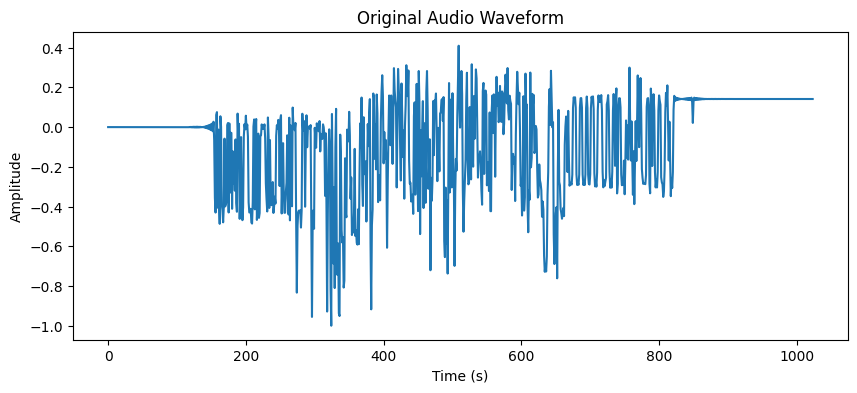

In [33]:
# Plotting
plt.figure(figsize=(10, 4))
# Plot 1: Original Audio Waveform
#plt.subplot(4, 1, 1)
#plt.plot(t, x)
plt.plot(audio_data)
plt.title('Original Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Text(0.5, 1.0, 'STFT Spectrogram')

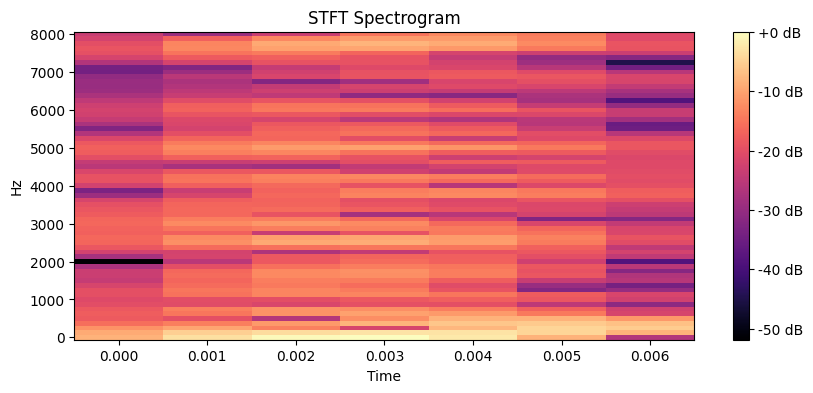

In [34]:
# Plotting
plt.figure(figsize=(10, 4))
# Plot 2: STFT Spectrogram
#plt.subplot(4, 1, 2)
#librosa.display.specshow(librosa.amplitude_to_db(amp_spec, ref=np.max),
                         #sr=sample_rate, x_axis='time', y_axis='hz')
librosa.display.specshow(librosa.amplitude_to_db(amp_spec, ref=np.max),
                         sr=sample_rate, hop_length=hop_size, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Spectrogram')


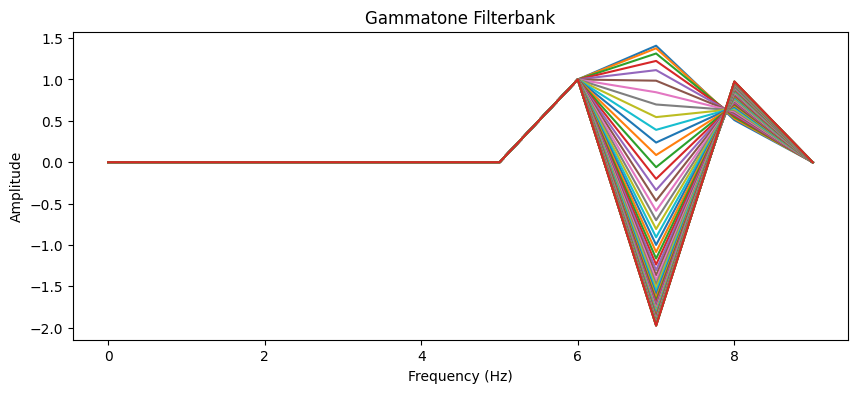

In [35]:

# Plot Gammatone filterbank
plt.figure(figsize=(10, 4))
for i, cf in enumerate(center_freqs):
    plt.plot(fbank[i], label=f'{int(cf)} Hz')
plt.title('Gammatone Filterbank')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

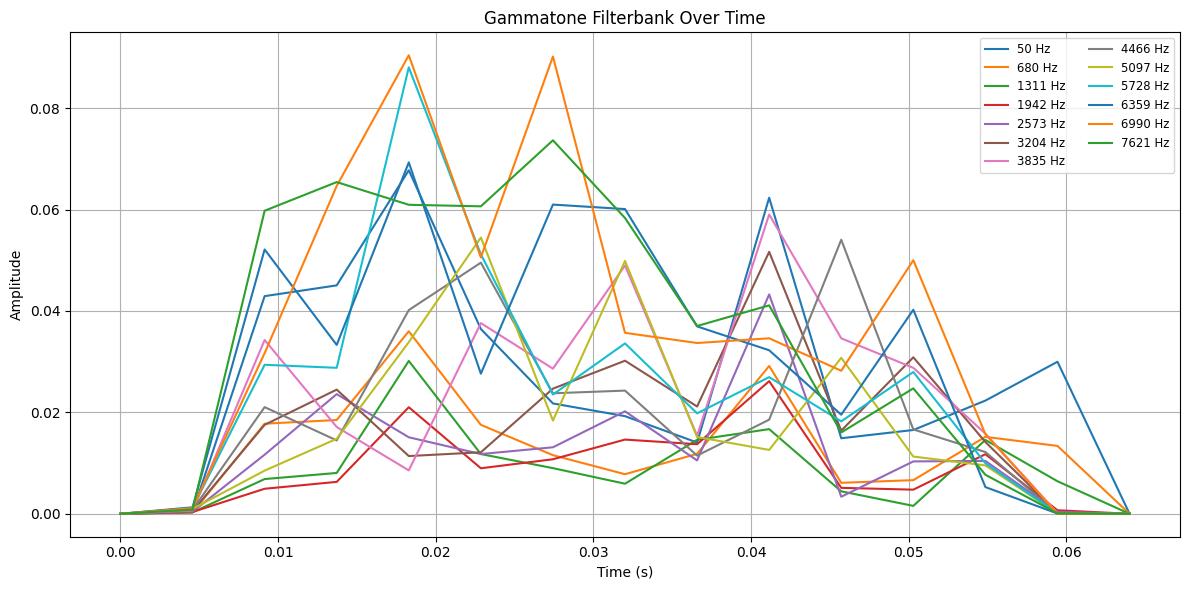

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming gammatone_features is a 2D array (frequency x time)
plt.figure(figsize=(12, 6))
time_axis = np.linspace(0, len(audio_data) / sample_rate, gammatone_features.shape[1])
frequency_axis = np.linspace(f_min, sample_rate / 2, gammatone_features.shape[0])

# Plot each frequency band over time with reduced interval for clarity
for i, frequency in enumerate(frequency_axis):
    if i % 5 == 0:  # Adjust this value to control how many lines are plotted
        plt.plot(time_axis, gammatone_features[i, :], label=f'{int(frequency)} Hz')

plt.title('Gammatone Filterbank Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust the number of columns for readability
plt.grid(True)
plt.tight_layout()
plt.show()


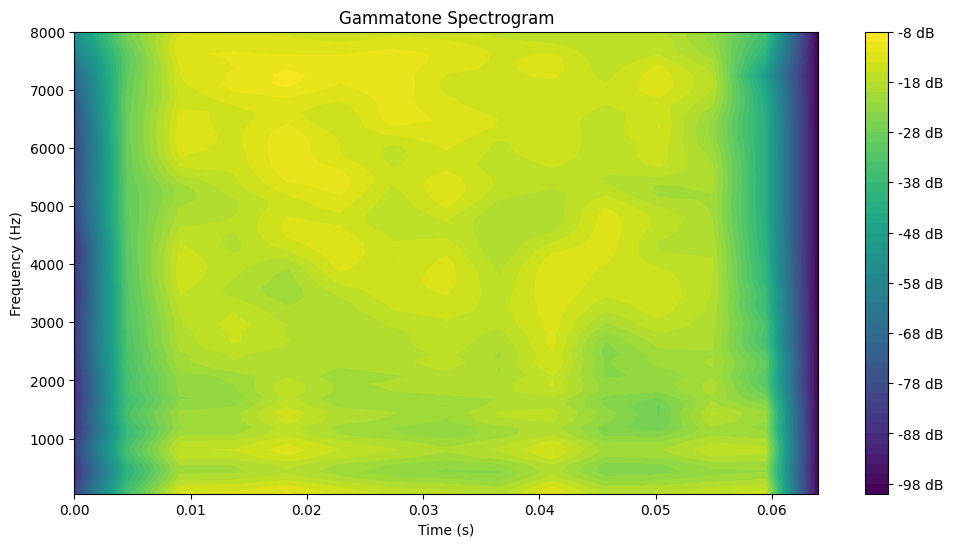

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Gammatone spectrogram
plt.figure(figsize=(12, 6))
time_axis = np.linspace(0, len(audio_data) / sample_rate, gammatone_features.shape[1])
frequency_axis = np.linspace(f_min, sample_rate / 2, gammatone_features.shape[0])

# Contour plot
plt.contourf(time_axis, frequency_axis, 10 * np.log10(gammatone_features + 1e-10), levels=50, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Gammatone Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


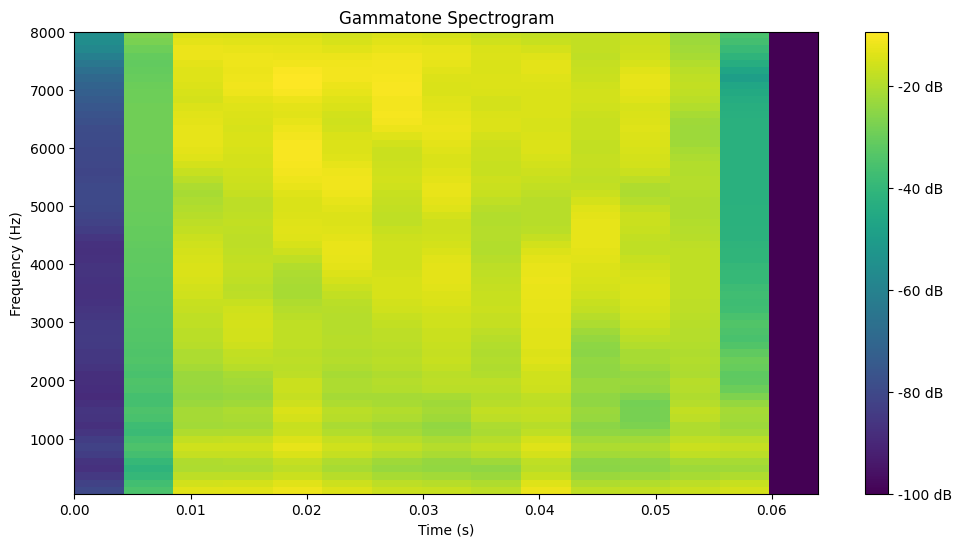

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Define parameters
frame_size = 128  # 128 samples per frame
hop_size = 16     # 16 samples hop
num_channels = 64
window_time = 0.004  # 4 ms window
hop_time = 0.004     # 4 ms hop
sample_rate = 16000
f_min = 50

# Generate time and frequency axes
time_axis = np.linspace(0, len(audio_data) / sample_rate, gammatone_features.shape[1])
frequency_axis = np.linspace(f_min, sample_rate / 2, num_channels)

# Plot Gammatone spectrogram
plt.figure(figsize=(12, 6))
plt.imshow(10 * np.log10(gammatone_features + 1e-10), aspect='auto', origin='lower',
           extent=[time_axis[0], time_axis[-1], f_min, sample_rate / 2], cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Gammatone Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


## **SUBFRAMING**

In [39]:
# Calculate the number of subframes
num_frames = gammatone_features.shape[1]
num_subframes = (num_frames * hop_size) // frame_size

# Initialize an array to hold the subframes
gammatone_subframes = np.zeros((num_channels, num_subframes, frame_size))

# Fill the subframes array
for i in range(num_subframes):
    start_idx = i * frame_size
    end_idx = start_idx + frame_size
    if end_idx <= gammatone_features.shape[1]:
        gammatone_subframes[:, i, :] = gammatone_features[:, start_idx:end_idx]

# Normalize the subframes to have zero mean and unit variance
mean = np.mean(gammatone_subframes, axis=(0, 1, 2))
std = np.std(gammatone_subframes, axis=(0, 1, 2))
normalized_subframes = (gammatone_subframes - mean) / std

<ipython-input-39-92dc6a06acc8>:18: RuntimeWarning: invalid value encountered in divide
  normalized_subframes = (gammatone_subframes - mean) / std


In [40]:
# Assuming you have labels for your data
labels = np.random.randint(0, 2, len(normalized_subframes))  # Replace with actual labels

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(normalized_subframes, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape the data to fit the input shape of the CNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [41]:
labels = np.array(df_frame_from_save['label'])
print(labels)

[0 0 0 ... 0 0 0]


## **CNN MODEL**

In [ ]:
'''
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(num_channels, frame_size, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Adjust the output layer based on the number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

 #Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))
'''
 #Define the CNN model with reduced complexity
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(num_channels, frame_size, 1)),
    #MaxPooling2D((2, 2)),
    #Conv2D(32, (3, 3), activation='relu'),
    #MaxPooling2D((2, 2)),
    Flatten(),
    Dense(6671, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with reduced batch size
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
# Check the original shape of X_train
original_shape = X_train.shape

# Calculate the correct number of samples
num_samples = original_shape[0] * original_shape[1] // (num_channels * frame_size)

# Reshape your data
X_train = X_train.reshape(num_samples, num_channels, frame_size, 1)
X_val = X_val.reshape(X_val.shape[0] * X_val.shape[1] // (num_channels * frame_size), num_channels, frame_size, 1)

# Define the CNN model with reduced complexity
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(num_channels, frame_size, 1)),
    Flatten(),
    Dense(128, activation='relu'),  # Adjust number of units as needed
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with reduced batch size
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


In [ ]:
print("Original shape of X_train:", original_shape)
print("Calculated number of samples:", num_samples)

# Reshape your data
X_train = X_train.reshape(num_samples, num_channels, frame_size, 1)
print("New shape of X_train:", X_train.shape)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Assuming X_train and X_val are already loaded with shape (38, 1, 128, 1)
X_train = np.random.rand(38, 1, 128, 1)  # Dummy data for testing
X_val = np.random.rand(10, 1, 128, 1)    # Dummy validation data
y_train = np.random.randint(0, 2, 38)    # Dummy labels
y_val = np.random.randint(0, 2, 10)      # Dummy validation labels

# Reshape your data to remove the single channel
X_train = X_train.reshape(-1, 128)
X_val = X_val.reshape(-1, 128)

# Define the model without convolutional layers
model = Sequential([
    Dense(128, activation='relu', input_shape=(128,)),  # Adjust input shape
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # Adjust the output layer based on the number of classes
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with reduced batch size
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Print the summary of the model
model.summary()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Sample data (replace with your actual data)
X_train = np.random.rand(38, 1, 128, 1)  # Dummy data for testing
X_val = np.random.rand(10, 1, 128, 1)    # Dummy validation data
y_train = np.random.randint(0, 2, 38)    # Dummy labels
y_val = np.random.randint(0, 2, 10)      # Dummy validation labels

# Reshape data
X_train = X_train.reshape(-1, 128)
X_val = X_val.reshape(-1, 128)

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(128,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Model summary
model.summary()


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Dummy data for illustration (replace with your actual data)
X_train = np.random.rand(38, 64, 16, 1)  # Adjust shape based on your data
X_val = np.random.rand(10, 64, 16, 1)
y_train = np.random.randint(0, 2, 38)
y_val = np.random.randint(0, 2, 10)

# Define the model architecture
def cough_detection_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    # First convolutional layer
    x = layers.Conv2D(16, kernel_size=(9, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)

    # Second convolutional layer
    x = layers.Conv2D(16, kernel_size=(5, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)

    # Flatten the output
    x = layers.Flatten()(x)

    # Dense layers with dropout
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # Output layer
    outputs = layers.Dense(1, activation="sigmoid")(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[
        "accuracy",
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc_roc', curve='ROC'),
        metrics.AUC(name='auc_pr', curve='PR'),
        metrics.F1Score(name='f1_score')
    ])

    return model

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# Implement k-fold cross-validation
k = 2
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Placeholder for metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []
auc_pr_scores = []

# Cross-validation loop
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Apply SMOTE for oversampling
    X_train_2d = X_train_fold.reshape(X_train_fold.shape[0], -1)
    smote = SMOTE()
    X_train_resampled_2d, y_train_resampled = smote.fit_resample(X_train_2d, y_train_fold)
    X_train_resampled = X_train_resampled_2d.reshape(-1, 64, 16, 1)

    # Reshape validation data
    X_val_2d = X_val_fold.reshape(X_val_fold.shape[0], -1)
    X_val_resampled_2d, y_val_resampled = smote.fit_resample(X_val_2d, y_val_fold)
    X_val_resampled = X_val_resampled_2d.reshape(-1, 64, 16, 1)

    # Convert labels to float32
    y_train_resampled = y_train_resampled.astype('float32')
    y_val_resampled = y_val_resampled.astype('float32')

    # Define model
    model = cough_detection_model(input_shape=(64, 16, 1))

    # Fit the model
    model.fit(X_train_resampled, y_train_resampled, batch_size=32, epochs=10,
              validation_data=(X_val_resampled, y_val_resampled), verbose=1,
              class_weight=class_weights)

    # Evaluate the model
    y_pred = model.predict(X_val_resampled)
    y_pred_classes = (y_pred > 0.5).astype(int)

    accuracy_scores.append(accuracy_score(y_val_resampled, y_pred_classes))
    precision_scores.append(precision_score(y_val_resampled, y_pred_classes))
    recall_scores.append(recall_score(y_val_resampled, y_pred_classes))
    f1_scores.append(f1_score(y_val_resampled, y_pred_classes))
    auc_roc_scores.append(model.evaluate(X_val_resampled, y_val_resampled, verbose=0)[4])
    auc_pr_scores.append(model.evaluate(X_val_resampled, y_val_resampled, verbose=0)[5])

    # Print confusion matrix for current fold
    cm = confusion_matrix(y_val_resampled, y_pred_classes)
    print("Confusion Matrix for current fold:")
    print(cm)

# Print average scores
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average AUC-ROC: {np.mean(auc_roc_scores):.4f}")
print(f"Average AUC-PR: {np.mean(auc_pr_scores):.4f}")


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Dummy data (replace with actual data)
X_train = np.random.rand(38, 64, 16, 1)
X_val = np.random.rand(10, 64, 16, 1)
y_train = np.random.randint(0, 2, 38)
y_val = np.random.randint(0, 2, 10)

# Model definition
def cough_detection_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(16, kernel_size=(9, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Conv2D(16, kernel_size=(5, 3), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 1))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[
        "accuracy",
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc_roc', curve='ROC'),
        metrics.AUC(name='auc_pr', curve='PR')
    ])

    return model

# Class weights calculation
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Metrics storage
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []
auc_pr_scores = []

# Cross-validation loop
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # SMOTE with k_neighbors=2
    X_train_2d = X_train_fold.reshape(X_train_fold.shape[0], -1)
    smote = SMOTE(k_neighbors=2)
    X_train_resampled_2d, y_train_resampled = smote.fit_resample(X_train_2d, y_train_fold)
    X_train_resampled = X_train_resampled_2d.reshape(-1, 64, 16, 1)

    # Model initialization
    model = cough_detection_model(input_shape=(64, 16, 1))

    # Model training
    model.fit(X_train_resampled, y_train_resampled, batch_size=32, epochs=10,
              validation_data=(X_val_fold, y_val_fold), verbose=1, class_weight=class_weights)

    # Evaluation
    y_pred = model.predict(X_val_fold)
    y_pred_classes = (y_pred > 0.5).astype(int)

    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_classes))
    precision_scores.append(precision_score(y_val_fold, y_pred_classes, zero_division=0))
    recall_scores.append(recall_score(y_val_fold, y_pred_classes))
    f1_scores.append(f1_score(y_val_fold, y_pred_classes))
    auc_roc_scores.append(model.evaluate(X_val_fold, y_val_fold, verbose=0)[4])
    auc_pr_scores.append(model.evaluate(X_val_fold, y_val_fold, verbose=0)[5])

    # Confusion matrix
    cm = confusion_matrix(y_val_fold, y_pred_classes)
    print("Confusion Matrix for current fold:")
    print(cm)

# Average metrics
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average AUC-ROC: {np.mean(auc_roc_scores):.4f}")
print(f"Average AUC-PR: {np.mean(auc_pr_scores):.4f}")



## **Sources**
Druzhig/convolutional-model
discuss.tensorflow.org/t/how-to-use-precision-or-f1-score-metrics-in-a-multiclass-classification-shape-error/18162**

## **Evaluation**

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate evaluation metrics
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')


In [ ]:
 #Calculate AUC
try:
    auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    print(f'AUC: {auc}')
except ValueError as e:
    print(f'AUC calculation error: {e}')

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


## **Visualization of train histroy**

In [ ]:
# Visualization of training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
plt.figure(figsize=(12, 4))#
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## **DONT CONTINUE ROUGH WORK BELOW**
